In [2]:
import openturns as ot
import numpy as np
import matplotlib as mpl

# Implementation of AK-IS

## Sources :  
* Echard, B.,Assessment by kriging of the reliability of structures subjected to fatigue stress, PhD Thesis, Université Blaise Pascal, 2012


This notebook implements the AK- IS method which couples Gaussian Process based surrogate model and Importance Sampling by FORM.


In case of rare event probability estimation, the surrogate model has to be accurate in the zones that are relevant to the failure probability estimation i.e. in the vicinity of failure threshold $T$ and in the high probability content regions. The use of the exact function $\phi$ and its surrogate $\hat{\phi}$ in the probability calculation will lead to the same result if $\forall \mathbf{x} \in \mathbb{R}^d, \mathbf{1}_{\phi(\mathbf{x})>T} = \mathbf{1}_{\hat{\phi}(\mathbf{x},\mathcal{X})>T}$. In other words, the surrogate model might not be representative of the exact function outside the zones of interest as it does not take part of the probability estimation. From the initial training set $\mathcal{X}$, the Gaussian process properties (i.e. estimation of the predicted error variance) are  valuable to determine the additional samples which have to be evaluated on $\phi(\cdot)$ to refine its surrogate model. Different refinement strategies have been developed in the literature. Here, the method described in [Echard 2012] is implemented  ("U criterion").


This method determines a new sample point $\mathbf{x}$ to add to the training set $\mathcal{X}$ by solving the following optimisation problem:
\begin{equation}
\underset{\mathbf{x}}{\max}  \left[1 - \Phi_{0,1}\left( \frac{|T-\hat{\phi}(\mathbf{x},\mathcal{X})|}{\hat{\sigma}(\mathbf{x},\mathcal{X})}\right)\right], \label{eq:echard}
\end{equation}
where $\Phi_{0,1}(\cdot)$ is the cdf of the standard Gaussian distribution, $\hat{\phi}$ the mean prediction of the Kriging and $\hat{\sigma}$ the estimated standard deviation of the prediction error. The used criterion generates a sample for which the Kriging prediction is closed to the threshold  (numerator) and which presents a high prediction error (denominator). Due to the monotonicity of the involved cdf, the optimisation problem is equivalent to:
\begin{equation}
\underset{\mathbf{x}}{\min}\;  \frac{|T-\hat{\phi}(\mathbf{x},\mathcal{X})|}{\hat{\sigma}(\mathbf{x},\mathcal{X})}. \label{eq:echard2}
\end{equation}
This criterion has been coupled with Importance Sampling. In practice, the optimisation problem is not solved, and given a sample set $\{\mathbf{X}_1,\dots, \mathbf{X}_N\}$ provided by IS the new sample which will be added to the training set is determined by
\begin{equation*}
\mathbf{X} = \underset{\mathbf{X}_1,\dots,\mathbf{X}_N}{\text{argmin}}  \left\{\frac{|T-\hat{\phi}(\mathbf{X}_1,\mathcal{X})|}{\hat{\sigma}(\mathbf{X}_1,\mathcal{X})},\dots, \frac{|T-\hat{\phi}(\mathbf{X}_N,\mathcal{X})|}{\hat{\sigma}(\mathbf{X}_N,\mathcal{X})}     \right\}.
\end{equation*}



In this notebook, this criterion is implemented with Importance Sampling.

First a FORM analysis is performed to get the design point. Then an auxiliary density is placed at this design point. Finally, adaptive refinement of Kriging model is performed from the samples generated with the auxiliary density.

## Definition of algorithm AK-IS  class (implemented here with "U" criterion, and FORM to find the MPP, see sources)

In [3]:
### Definition of parameters
# event : ThresholdEvent based on composite vector of input variables on limit state function 
# n_IS : number of IS samples at the MPP found by FORM
# n_DoE : number of samples in initial Kriging DoE
# sim_budget : total simulation budget available
# basis : basis of kriging model
# cov_model : covariance model of kriging
# FORM_solver : FORM solver 
# u_criterion : threshold value for "u criterion"
# verbose : verbosity parameter 

class AK_ISAlgorithm(object):
    
    def __init__(self,event,n_IS,n_DoE,sim_budget,basis,cov_model,FORM_solver,u_criterion=2,verbose = False):
        self.n_IS = n_IS
        self.n_DoE = n_DoE
        self.limit_state_function = event.getFunction()
        self.S = event.getThreshold()
        self.basis = basis
        self.cov_model = cov_model
        self.dim = event.getAntecedent().getDimension()
        self.proba = 0.
        self.cv = 0.
        self.distrib = event.getAntecedent().getDistribution()
        self.tol_var_krig = cov_model.getNuggetFactor()
        self.nb_eval = 0
        self.U_criterion = u_criterion
        self.DoE = None
        self.kriging_model = None
        self.verbose = verbose
        self.samples = None
        self.FORM_solver = FORM_solver
        self.inv_isoprobtrans = self.distrib.getInverseIsoProbabilisticTransformation()
        self.max_sim = sim_budget
        self.FORM_result = None
        self.operator =  event.getOperator()
        
    #Function determining the U criterion of AK -IS
    def compute_U(self,my_krig,list_id_evaluated):
        
        y_pred = my_krig.getConditionalMean(self.samples)
        y_var_pred = my_krig.getConditionalMarginalVariance(self.samples)
        
        U = np.abs(ot.Sample([ot.Point([self.S])]*int(self.n_IS))-y_pred)/np.sqrt(y_var_pred)
            
        if len(list_id_evaluated)>0:
            U[list_id_evaluated] = 5e5
        return U
    
    # FORM COMPUTATION
    def compute_FORM(self):
        vect = ot.RandomVector(self.distrib)
        G = ot.CompositeRandomVector(self.limit_state_function, vect)
        event = ot.ThresholdEvent(G,self.operator, self.S)
        #FORM algorithm to get the MPP
        algo = ot.FORM(self.FORM_solver, event, self.distrib.getMean())
        algo.run()
        result_FORM = algo.getResult()
        if self.verbose == True:
            print('Estimation of probability with FORM',result_FORM.getEventProbability())
        self.FORM_result = result_FORM
        
    #Function computing the probability of failure
    def compute_proba(self):

            #Computation of FORM
            self.compute_FORM()
            # Derivation of auxiliary density and sampling
            myImportance = ot.Normal(self.dim)
            myImportance.setMean(self.FORM_result.getStandardSpaceDesignPoint())
            samples_std_space = myImportance.getSample(self.n_IS)
            self.samples_std_space = samples_std_space
            self.samples = self.inv_isoprobtrans(samples_std_space)
            
            #Calculation of weights in standard space
            norm_law = ot.Normal(np.zeros(self.dim), np.ones(self.dim), ot.IdentityMatrix(self.dim))
            weights = [norm_law.computePDF(x)/myImportance.computePDF(x) for x in samples_std_space]

            #Generation of DoE
            DoE_inputs = self.samples[0:self.n_DoE]
            #Calculation of True function of the DoE
            DoE_responses =self.limit_state_function(DoE_inputs)
            list_id_samples_evaluated = np.linspace(0,self.n_DoE-1,self.n_DoE,dtype = int).tolist()
            
            #Definition of Kriging algorithm
            algokriging = ot.KrigingAlgorithm(DoE_inputs, 
                                              DoE_responses,
                                              self.cov_model,
                                              self.basis)
            algokriging.run()
            my_krig = algokriging.getResult()
            updated_cov = my_krig.getCovarianceModel()
            U_y_pred = self.compute_U(my_krig,list_id_samples_evaluated)
            
            id_opt_U=np.argmin(U_y_pred)
            current_min_U = np.min(U_y_pred)
            
            nb_pt_sim = 0
            
            list_id_samples_evaluated.append(id_opt_U)
            
            while nb_pt_sim<self.max_sim and current_min_U < self.U_criterion:
                    #evaluation of true function
                    x_new = self.samples[int(id_opt_U)]
                    y_new = self.limit_state_function(x_new)

                    DoE_inputs.add(x_new)
                    DoE_responses.add(y_new)
                    # Definition of Kriging model

                    startingPoint =updated_cov.getScale()
                    algokriging = ot.KrigingAlgorithm(DoE_inputs, 
                                                      DoE_responses,
                                                      covarianceModel,
                                                      basis)
                    
                    solver_kriging = ot.NLopt('GN_DIRECT')
                    
                    solver_kriging.setStartingPoint(startingPoint)
                    
                    algokriging.setOptimizationAlgorithm(solver_kriging)
                    
                    algokriging.setOptimizationBounds(ot.Interval([0.01]*self.dim, [100]*self.dim))
                    #self.algo_krig = algokriging

                    algokriging.run()

                    my_krig = algokriging.getResult()
                    updated_cov = my_krig.getCovarianceModel()
                    # computation of U
                    U_y_pred = self.compute_U(my_krig,list_id_samples_evaluated)
                    current_min_U=np.min(U_y_pred)
                    id_opt_U = np.argmin(U_y_pred)         
                    nb_pt_sim = nb_pt_sim+1
                    list_id_samples_evaluated.append(id_opt_U)
                   
                    y = my_krig.getConditionalMean(self.samples)
                    
                    I = [self.operator(y[i][0],self.S) for i in range(self.n_IS)]
                    
                    #[print(y[i][0])for i in range(self.n_IS)]
                    
                    int_I = [int(i) for i in I]
                    
                    Pf = 1/self.n_IS*np.sum(np.array(int_I)*weights)
                    self.proba = Pf
                    self.nb_eval = self.n_DoE+nb_pt_sim
                    self.DoE = [DoE_inputs,DoE_responses]
                    self.kriging_model = my_krig

                    if self.verbose == True:
                        if nb_pt_sim == 1:
                            print('current_min_U', '| Nb_sim',' | Probability estimate')
                            print('{:9e}'.format(current_min_U),' | ','{:5d}'.format(int(nb_pt_sim)),' |      ','{:10e}'.format(Pf))

                        else:
                            print('{:9e}'.format(current_min_U),' | ','{:5d}'.format(int(nb_pt_sim)),' |      ','{:10e}'.format(Pf))
                            
            return 
                   
    #Accessor to the number of evaluated samples             
    def getSimBudget(self):
        return self.nb_eval
    
    #Accessor to the kriging model 
    def getKrigingModel(self):
        return self.kriging_model
                   
    #Accessor to the DoE
    def getDoE(self):
        return self.DoE
    
    #Accessor to the failure probability
    def getFailureProbability(self):
        return self.proba
    
    #Accessor to the MonteCarlo samples
    def getIS_Samples(self):
        return self.samples

## Numerical experiments


## Experiment 1 : "Non linear oscillator"

$G(c_1,c_2,m,r,t_1,F_1)  = 3r-\left|\frac{2 F_1}{m \omega_0^2}sin\left(\frac{\omega_0 t_1}{2}\right)\right|$

with : 
* $\omega_0 = \sqrt{\left(\frac{c_1+c_2}{m}\right)}$
* $m \sim \mathcal{N}(1,0.05)$
* $c_1 \sim \mathcal{N}(1,0.1)$
* $c_2 \sim \mathcal{N}(0.1,0.01)$
* $r \sim \mathcal{N}(0.5,0.05)$
* $F_1 \sim \mathcal{N}(1.,0.2)$
* $r \sim \mathcal{N}(1.,0.2)$

### Definition of input vector distribution

In [4]:
dist_c1=ot.Normal(1, 0.1)
dist_c2=ot.Normal(0.1, 0.01)
dist_m=ot.Normal(1.,0.05 )
dist_r =ot.Normal(0.5, 0.05)
dist_t1 =ot.Normal(1., 0.2)
dist_F1=ot.Normal(1., 0.2)
std_dev = [dist_c1.getStandardDeviation()[0],dist_c2.getStandardDeviation()[0],dist_m.getStandardDeviation()[0],
           dist_r.getStandardDeviation()[0],dist_t1.getStandardDeviation()[0],dist_F1.getStandardDeviation()[0]]
dim_inputs=6
marginals = [dist_c1,dist_c2,dist_m,dist_r,dist_t1,dist_F1]
dist_x = ot.ComposedDistribution(marginals)

### Definition of model

In [5]:
#Definition of classical function
def non_lin_osc(x):
    c1 = x[0]
    c2  = x[1]
    m = x[2]
    r = x[3]
    t1 = x[4]
    F1= x[5]
    
    omega = np.sqrt((c1+c2)/m)
    
    G = 3*r - np.abs(2*F1/(m*omega**2)*np.sin(omega*t1/2))
    return [G]

# Definition of pythonfunction
non_lin_osc = ot.PythonFunction(6, 1, non_lin_osc)

# Creation of event
vect = ot.RandomVector(dist_x)
G = ot.CompositeRandomVector(non_lin_osc, vect)
event_osc = ot.ThresholdEvent(G, ot.Less(), 0.0)

### Verification of true probability

In [6]:
n_MC = np.int(1e6)

# create a Monte Carlo algorithm
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event_osc, experiment)
algo.setMaximumOuterSampling(int(n_MC))
algo.setMaximumCoefficientOfVariation(0.01)
algo.run()
# retrieve results
result = algo.getResult()
probability = result.getProbabilityEstimate()
print('Reference probability:', probability)

D:\mbalesde\Logiciels\Externes\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


Reference probability: 0.0284842319430315


### Definition of AK IS

In [7]:
# Definition of Kriging model
dim_osc = 6
basis = ot.ConstantBasisFactory(dim_inputs).build()
covarianceModel = ot.SquaredExponential([0.1]*dim_osc, [1.0])

n_IS_osc = 1000
n_DoE_osc = 40
sim_budget_osc = 200
verbose = True
my_AK_non_lin_osc = AK_ISAlgorithm(event_osc,
                                    n_IS_osc,
                                    n_DoE_osc,
                                    sim_budget_osc,                                                                   
                                    basis,
                                    covarianceModel,
                                    ot.Cobyla(),
                                    2,
                                    verbose)


### Computation of failure probability with AK-IS

In [8]:
#computation of probability with AK-IS
my_AK_non_lin_osc.compute_proba()

Estimation of probability with FORM 0.031085156351391082
current_min_U | Nb_sim  | Probability estimate
1.171688e-02  |      1  |       3.011827e-02
2.019080e-01  |      2  |       2.995356e-02
4.458967e-01  |      3  |       3.011827e-02
4.835248e-01  |      4  |       3.011827e-02
2.369908e-01  |      5  |       3.001493e-02


D:\mbalesde\Logiciels\Externes\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt


1.082952e+00  |      6  |       3.001493e-02
2.488617e+00  |      7  |       3.001493e-02


In [9]:
print('Probability of failure:',my_AK_non_lin_osc.getFailureProbability())
print('Simulation budget:',my_AK_non_lin_osc.getSimBudget())

Probability of failure: 0.030014925766454405
Simulation budget: 47


## Extension of experiment 1 to rare event

$G(c_1,c_2,m,r,t_1,F_1)  = 3r-\left|\frac{2 F_1}{m \omega_0^2}sin\left(\frac{\omega_0 t_1}{2}\right)\right|$

with : 
* $\omega_0 = \sqrt{\left(\frac{c_1+c_2}{m}\right)}$
* $m \sim \mathcal{N}(1,0.005)$
* $c_1 \sim \mathcal{N}(1,0.0015)$
* $c_2 \sim \mathcal{N}(0.1,0.01)$
* $r \sim \mathcal{N}(0.5,0.02)$
* $F_1 \sim \mathcal{N}(1.,0.1)$
* $r \sim \mathcal{N}(1.,0.1)$

In [10]:
# Definition of python function and input vector distribution
non_lin_osc = ot.PythonFunction(6, 1, non_lin_osc)
dist_c1=ot.Normal(1, 0.005)
dist_c2=ot.Normal(0.1, 0.0015)
dist_m=ot.Normal(1.,0.01 )
dist_r =ot.Normal(0.5, 0.02)
dist_t1 =ot.Normal(1., 0.1)
dist_F1=ot.Normal(1., 0.1)
std_dev = [dist_c1.getStandardDeviation()[0],dist_c2.getStandardDeviation()[0],dist_m.getStandardDeviation()[0],
           dist_r.getStandardDeviation()[0],dist_t1.getStandardDeviation()[0],dist_F1.getStandardDeviation()[0]]
dim_inputs=6
marginals = [dist_c1,dist_c2,dist_m,dist_r,dist_t1,dist_F1]
dist_x = ot.ComposedDistribution(marginals)

# Creation of event
vect = ot.RandomVector(dist_x)
G = ot.CompositeRandomVector(non_lin_osc, vect)
event_osc_rare = ot.ThresholdEvent(G, ot.Less(), 0.0)

### Estimation of reference probability with Monte Carlo

In [11]:
#CMC estimation
n_MC = np.int(1e6)
# create a Monte Carlo algorithm
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event_osc_rare, experiment)
algo.setMaximumOuterSampling(int(n_MC))
algo.run()

# retrieve results
result = algo.getResult()
probability = result.getProbabilityEstimate()
print('Reference probability:', probability)
print('Coefficient of variation:',result.getCoefficientOfVariation())

D:\mbalesde\Logiciels\Externes\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


Reference probability: 3.7000000000000086e-05
Coefficient of variation: 0.1643959458959584


### Definition of AK-IS

In [12]:
# Definition of Kriging model
dim_osc = 6
basis = ot.ConstantBasisFactory(dim_inputs).build()
covarianceModel = ot.SquaredExponential([0.1]*dim_osc, [1.0])

#covarianceModel = ot.MaternModel(dim_inputs)
n_IS_osc = 5000
n_DoE_osc = 40
sim_budget_osc = 200
verbose = True
my_AK_non_lin_osc_rare = AK_ISAlgorithm(event_osc_rare,
                                    n_IS_osc,
                                    n_DoE_osc,
                                    sim_budget_osc,                                                                   
                                    basis,
                                    covarianceModel,
                                    ot.Cobyla(),
                                    2,
                                    verbose)

### Estimation of probability with AK-IS

In [13]:
my_AK_non_lin_osc_rare.compute_proba()

Estimation of probability with FORM 3.393401583515943e-05
current_min_U | Nb_sim  | Probability estimate
1.816446e-01  |      1  |       3.156165e-05


D:\mbalesde\Logiciels\Externes\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt


6.271955e-01  |      2  |       3.163528e-05
1.125826e+00  |      3  |       3.163528e-05
1.670211e+00  |      4  |       3.163528e-05
1.841905e+00  |      5  |       3.163528e-05
1.819317e+00  |      6  |       3.163528e-05
2.274399e+00  |      7  |       3.163528e-05


In [14]:
print('Probability of failure:',my_AK_non_lin_osc_rare.getFailureProbability())
print('Simulation budget:',my_AK_non_lin_osc_rare.getSimBudget())

Probability of failure: 3.163528089789451e-05
Simulation budget: 47


## Experiment 2 : "four branch function"

$$G(x_1,x_2) = min \begin{pmatrix}3+0.1(x_1-x_2)^2-\frac{(x_1+x_2)}{\sqrt{2}};\\3+0.1(x_1-x_2)^2+\frac{(x_1+x_2)}{\sqrt{2}};\\
(x_1-x_2)+ \frac{k}{\sqrt{2}};\\
(x_2-x_1)+ \frac{k}{\sqrt{2}}
\end{pmatrix}$$

with : 
* $k$ is equal to 6 or 7
* $x_1 \sim \mathcal{N}(0,1)$
* $x_2 \sim \mathcal{N}(0,1)$


This case involves 4 failure regions. It is expected that the algorithm finds only one region and consequently under estimate the failure probability

### Definition of input variable probability distributions

In [15]:
dim_inputs = 2
dist_x = ot.Normal([0.0, 0.0], [1.0, 1.0], ot.CorrelationMatrix(dim_inputs))
inputVector = ot.RandomVector(dist_x)

### Definition of limit state function

In [16]:
#Definition of limit state function
def four_branch(x):
    x1 = x[0]
    x2  = x[1]
    k = x[2]
    
    g1 = 3+0.1*(x1-x2)**2-(x1+x2)/np.sqrt(2)
    g2 = 3+0.1*(x1-x2)**2+(x1+x2)/np.sqrt(2)
    g3 = (x1-x2)+k/np.sqrt(2)
    g4 =(x2-x1)+k/np.sqrt(2)
    
    return [min((g1,g2,g3,g4))]

# Definition of python function
my_four_branch = ot.PythonFunction(3, 1, four_branch)

# Transformation of python function to parametric function
index_frozen = [2]
my_four_branch_6 = ot.ParametricFunction(my_four_branch, index_frozen, [6])
my_four_branch_7 = ot.ParametricFunction(my_four_branch, index_frozen, [7])

### Estimation of reference probability

In [17]:
n_MC = np.int(1e4)

# Creation of event
ot.RandomGenerator.SetSeed(1)
vect = ot.RandomVector(dist_x)
G = ot.CompositeRandomVector(my_four_branch_7, vect)
event_4b = ot.ThresholdEvent(G, ot.Less(), 0.0)

# create a Monte Carlo algorithm
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event_4b, experiment)
algo.setMaximumOuterSampling(int(n_MC))
algo.run()

# retrieve results
result = algo.getResult()
probability = result.getProbabilityEstimate()
print('Pf=', probability)

Pf= 0.0024999999999999988


D:\mbalesde\Logiciels\Externes\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


### Definition of AK-IS experiment

In [18]:
# Definition of Kriging model
dim_4b = 2
basis = ot.ConstantBasisFactory(dim_4b).build()

FORM_solver = ot.Cobyla()
covarianceModel = ot.MaternModel(dim_4b)
n_MC_4b = 10000
n_DoE_4b = 20
verbose = True
sim_budget = 100

my_AK_four_branch = AK_ISAlgorithm(event_4b,
                                    n_MC_4b,
                                    n_DoE_4b,
                                   sim_budget,
                                    basis,
                                    covarianceModel,
                                    ot.Cobyla(),
                                    2,
                                    verbose)

### Computation of the failure probability with AK-IS

In [19]:
#computation of probability with AK-MCS
my_AK_four_branch.compute_proba()

Estimation of probability with FORM 0.001349942350880145
current_min_U | Nb_sim  | Probability estimate
8.113475e-03  |      1  |       8.907685e-04


D:\mbalesde\Logiciels\Externes\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt
D:\mbalesde\Logiciels\Externes\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in true_divide


4.639856e-02  |      2  |       8.907685e-04
3.343982e-02  |      3  |       8.933861e-04
3.827974e-03  |      4  |       8.930885e-04
8.757914e-03  |      5  |       8.914099e-04
4.119483e-02  |      6  |       8.914099e-04
5.527834e-02  |      7  |       8.907162e-04
3.471198e-02  |      8  |       8.891030e-04
9.074630e-02  |      9  |       8.891030e-04
1.804991e-01  |     10  |       8.891030e-04
2.015137e-01  |     11  |       8.891030e-04
8.822365e-02  |     12  |       8.894058e-04
9.256547e-02  |     13  |       8.894605e-04
1.509917e-01  |     14  |       8.894605e-04
2.433702e-01  |     15  |       8.893424e-04
2.639178e-01  |     16  |       8.893424e-04
2.942870e-01  |     17  |       8.893424e-04
3.691120e-01  |     18  |       8.893424e-04
4.373355e-01  |     19  |       8.893424e-04
5.771042e-02  |     20  |       8.893424e-04
5.460006e-01  |     21  |       8.893424e-04
6.175561e-01  |     22  |       8.893424e-04
6.343442e-01  |     23  |       8.893424e-04
7.058863e-

 ### Post treatments

In [20]:
print('Probability of failure:',my_AK_four_branch.getFailureProbability())
print('Simulation budget:',my_AK_four_branch.getSimBudget())

Probability of failure: 0.0008893282498174369
Simulation budget: 54


In [21]:
#Kriging model 
kr = my_AK_four_branch.getKrigingModel()
[DoE_four_branch_x,DoE_four_branch_y]= my_AK_four_branch.getDoE()

D:\mbalesde\Logiciels\Externes\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
D:\mbalesde\Logiciels\Externes\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
D:\mbalesde\Logiciels\Externes\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Eithe

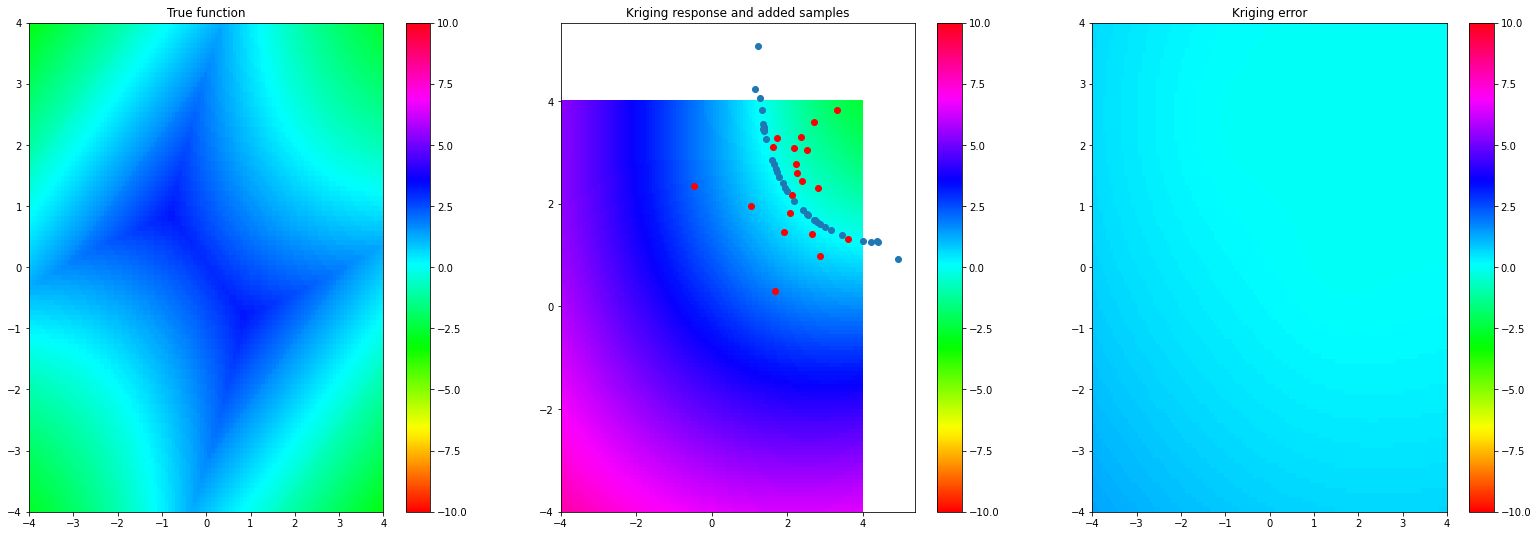

In [22]:
#Plot of surrogate model
import matplotlib.pyplot as plt

grid_size = 100
x1 = np.linspace(-4,4,grid_size)
x2 = np.linspace(-4,4,grid_size)

xx1,xx2 = np.meshgrid(x1,x2)

xx1_ = xx1.reshape((grid_size**2,1))
xx2_ = xx2.reshape((grid_size**2,1))

x = np.concatenate((xx1_,xx2_),1)
                  
                  
y_true = np.array(my_four_branch_7(x))
y_mean_krig =np.array(kr.getConditionalMean(x))     
                   
y_sigma_krig = np.array(np.sqrt(kr.getConditionalMarginalVariance(x)))

y_true = y_true.reshape((grid_size,grid_size))
y_mean_krig = y_mean_krig.reshape((grid_size,grid_size))
y_sigma_krig= y_sigma_krig.reshape((grid_size,grid_size))

cmap = mpl.cm.hsv
norm = mpl.colors.Normalize(vmin=-10, vmax=10)
%matplotlib inline 
fig, (ax0, ax1,ax2) = plt.subplots(ncols=3,figsize=(27,9))
im1 = ax0.pcolormesh(xx1,xx2,y_true,norm = norm,cmap = cmap)
fig.colorbar(im1, ax=ax0)
ax0.title.set_text('True function')

im2 = ax1.pcolormesh(xx1,xx2,y_mean_krig,norm = norm,cmap = cmap)
ax1.scatter(DoE_four_branch_x[0:my_AK_four_branch.n_DoE,0],DoE_four_branch_x[0:my_AK_four_branch.n_DoE,1],color = 'r')
ax1.scatter(DoE_four_branch_x[my_AK_four_branch.n_DoE:,0],DoE_four_branch_x[my_AK_four_branch.n_DoE:,1])
fig.colorbar(im2, ax=ax1)
ax1.title.set_text('Kriging response and added samples')

im3 = ax2.pcolormesh(xx1,xx2,y_sigma_krig,norm = norm,cmap = cmap)
fig.colorbar(im3, ax=ax2)
ax2.title.set_text('Kriging error')